In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from src.sindy_rl_functions import *

## Step 1: Load Processed Data
Load in lists of arrays containing empirically reported Qs (`qvals`), true probabilities of reward (`truevals`), and other control variables such as trial number and reward value (`control_inputs_training`). The lists are stored as zipped archives of numpy arrays and are already processed using the `preprocessing.ipynb` notebook. Change `study` to equal `2` to run analyses for study 2.

In [2]:
study = 1

qvalslist = np.load('data/study%s/study%s_qvals.npz' % (study, study))
truevalslist = np.load('data/study%s/study%s_truevals.npz' % (study, study))
control_inputs_training = np.load('data/study%s/study%s_control_inputs_training.npz' % (study, study))

qvalslist = [qvalslist[key] for key in qvalslist.keys()]
truevalslist = [truevalslist[key] for key in truevalslist.keys()]
control_inputs_training = [control_inputs_training[key] for key in control_inputs_training.keys()]
test = [i for i, x in enumerate(qvalslist)]

Create a csv for easy visualization.

In [3]:
processeddict = {'ID': [], 'trial': [], 'trial_type': [], 'reported_q': [], 'true_q': [], 'working_phone': []}
for i, x in enumerate(qvalslist):
    for j, y in enumerate(x):
        processeddict['ID'].append(i+1)
        processeddict['trial'].append(j)
        if j == 0:
            trialtype = 'initialization'
        elif (control_inputs_training[i][j][0] >=0) and (y >=0):
            trialtype = 'trial'
        elif y >=0:
            trialtype = 'preattentioncheck'
        else:
            trialtype = 'attentioncheck'
        processeddict['trial_type'].append(trialtype)
        processeddict['reported_q'].append(y)
        processeddict['true_q'].append(truevalslist[i][j])
        if control_inputs_training[i][j][0] == -1:
            wp = np.nan
        else:
            wp = control_inputs_training[i][j][0]
        processeddict['working_phone'].append(wp)
processeddf = pd.DataFrame(processeddict)
processeddf.to_csv('study%s_processed.csv' % study)

## Step 2: Generate a matrix of candidate functions and train SINDy
These are the main two functions. `SINDYlibrary()` generates a matrix of candidate functions for either single, double, or triple bandit problems. See the `sindy_rl_functions.py` script for exact functions. You can limit the functions to only the r-Q term assumed by the Rescorla-Wagner model by setting `rw=True`. 

The `testSINDY()` function trains SINDy on the loaded data and returns a discovered model. If you want to training SINDy on a specific subject and not all data, change `sub=None` to a number corresponding with the participant's index. If you want to leave out a subject to use in a testing set, change `testing=None` to `testing=True`, otherwise if you want to train SINDy on the entire dataset, keep `testing=None`. If you do decide to use `testing=True`, you can change `r2=None` to a value of your choice representing the minimum r2 you'd like SINDy to reach, if it can. Note that increasing the bar for r2 may increase the complexity of SINDy's returned model. If you would like SINDy to return a specific number of terms in its model, change `terms=None` to a value of your choice. If you'd like to train SINDy only on the first half trials for each participant, change `half=[]` to `half=[0]`. If you'd prefer to use the last half of trials, use `half=[1]` instead.  You can also run multiple tests on different random subjects by increasing the `runs` argument. If you'd like to limit the terms discoverable by SINDy to only the r-Q term assumed by the Rescorla-Wagner model, set  `rw=True`.

For our analyses, we set `sub=None` and `testing=None` to train SINDy on all data and return a model and fit indices covering all data. All other arguments are also set to their defaults (`r2=None`, `terms=None`, `half=[]`, `runs=1`). We do run both `rw=False` and `rw=True` to discover models that both exhaustively cover or matrix of candidate features detailed in Methods AND that which is limited to only RW terms. 

In [4]:
print('Model discovered with full candidate matrix:')
rw = False
generalized_library, feat_names = SINDYlibrary(1, rw)
model = testSINDy(qvalslist, control_inputs_training,
                  generalized_library, feat_names, rw=rw, runs=1)

print('\n\nModel discovered when restricted to only RW terms:')
rw = True
generalized_library, feat_names = SINDYlibrary(1, rw)
model = testSINDy(qvalslist, control_inputs_training,
                  generalized_library, feat_names, rw=rw, runs=1)

Model discovered with full candidate matrix:
['qvals[0]', 'rewards', 'time', 'choice[0]']
MSE of model coefficients: 2984.9389

All subjects, N=455
(qvals[0])' = 0.113 rewards + -0.248 qvals[0]^2
0.2038088671856224


Model discovered when restricted to only RW terms:
['qvals[0]', 'rewards', 'time', 'choice[0]']
MSE of model coefficients: 3179.4250

All subjects, N=455
(qvals[0])' = 0.166 (rewards-qvals[0])
0.15136042070953404


## Step 3: Visualize discovered models against empirical data

As an additional explorative measure of the Quadratic Q-Weighted model’s explanatory validity, we plotted the empirical trial-by-trial changes in expectation Q as a function of previous Q and previous reward. For ease of visualization, we binned previous Q into 10 discrete categories, each with a bin size of 0.1. Categories were labeled with the upper bound of each bin. The median change in Q is plotted for each of these previous Q categories. We also create a dataframe of predicted changes in Q following each of the discovered models in the previous step. These models are hardcoded below.

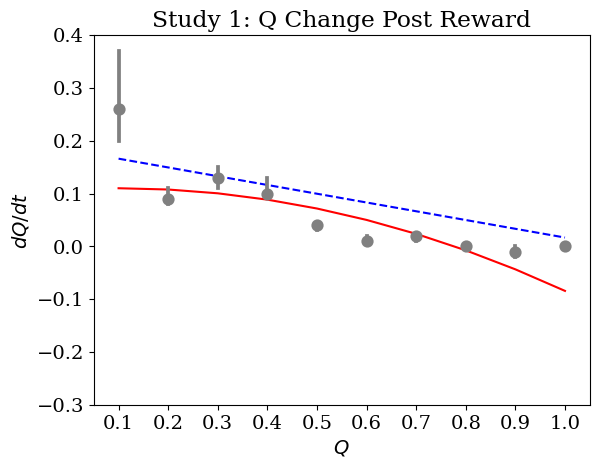

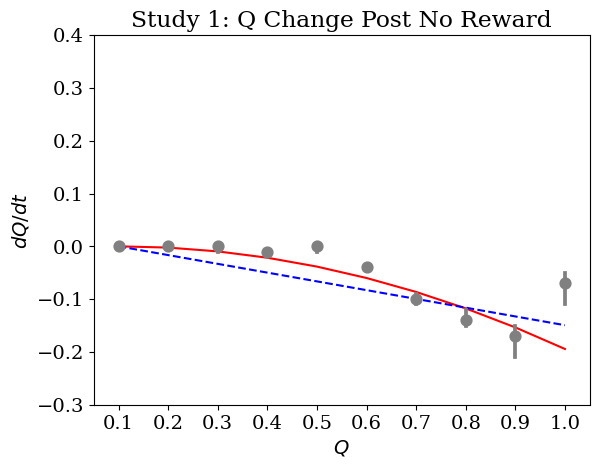

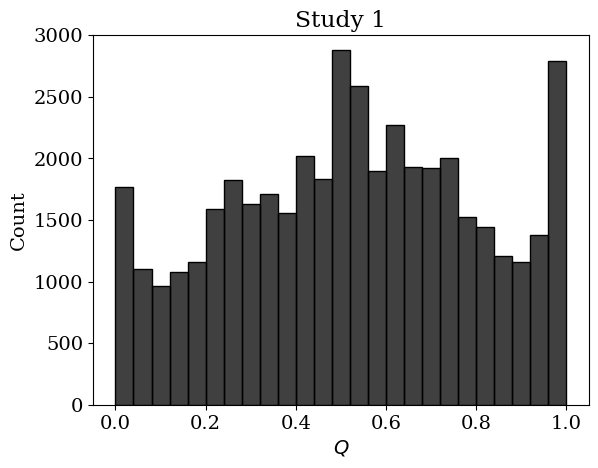

In [5]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

changelist = []
prevrewardlist = []
prevqlist = []
prevqcatlist = []
sublist = []
for i, x in enumerate(qvalslist):
    for j, q in enumerate(x):
        if j > 0:
            changelist.append(q - x[j-1])
            prevrewardlist.append(control_inputs_training[i][j-1][0])
            prevqlist.append(x[j-1])
            if np.isnan(x[j-1]) == False:
                if x[j-1] == 0:
                    prevqcatlist.append(0.1)
                else:
                    prevqcatlist.append(math.floor((x[j-1]+.0999)*10)/10)
            else:
                prevqcatlist.append(np.nan)
            sublist.append(i+1)
changedf = pd.DataFrame({'Q Change': changelist, 'Previous Reward': prevrewardlist, 'Previous Q': prevqlist,
                         'Previous Q Cat': prevqcatlist, 'Sub': sublist}).dropna()

s1r = [0.11 - 0.24*(x**2) for x in np.arange(0, 1, .1)]
s1nr = [0 - 0.24*(x**2) for x in np.arange(0, 1, .1)]
s2r = [0.1 - 0.17*(x**2) for x in np.arange(0, 1, .1)]
s2nr = [0 - 0.17*(x**2) for x in np.arange(0, 1, .1)]
s1r_rw = [0.166*(1-x) for x in np.arange(0, 1, .1)]
s1nr_rw = [0.166*(0-x) for x in np.arange(0, 1, .1)]
s2r_rw = [0.168*(1-x) for x in np.arange(0, 1, .1)]
s2nr_rw = [0.168*(0-x) for x in np.arange(0, 1, .1)]
fitdf = pd.DataFrame({'Q': np.arange(0, 10, 1), 's1r': s1r, 's1nr': s1nr, 's2r': s2r, 's2nr': s2nr,
                      's1r_rw': s1r_rw, 's1nr_rw': s1nr_rw, 's2r_rw': s2r_rw, 's2nr_rw': s2nr_rw})

sns.lineplot(x='Q', y='s%sr' % study, data=fitdf, linestyle='-', color='red')
sns.lineplot(x='Q', y='s%sr_rw' % study, data=fitdf, linestyle='--', color='blue')
sns.pointplot(x='Previous Q Cat', y='Q Change', estimator='median', errorbar='ci', color='grey',
        data=changedf[changedf['Previous Reward']==1], linestyles='none')
plt.xlabel(r'$Q$')
plt.ylabel(r'$dQ/dt$')
plt.ylim(-.3, .4)
plt.title('Study %s: Q Change Post Reward' % (study))
plt.show()

sns.lineplot(x='Q', y='s%snr' % study, data=fitdf, linestyle='-', color='red')
sns.lineplot(x='Q', y='s%snr_rw' % study, data=fitdf, linestyle='--', color='blue')
sns.pointplot(x='Previous Q Cat', y='Q Change', estimator='median', errorbar='ci', color='grey',
        data=changedf[changedf['Previous Reward']==0], linestyles='none')
plt.xlabel(r'$Q$')
plt.ylabel(r'$dQ/dt$')
plt.ylim(-.3, .4)
plt.title('Study %s: Q Change Post No Reward' % (study))
plt.show()

sns.histplot(changedf['Previous Q'], color='black', binwidth=.04)
plt.xlabel(r'$Q$')
plt.ylim(0,3000)
plt.title('Study %s' % study)
plt.show()

## Step 4: Read Stan model fits and compare BIC
Because the Stan models mentioned in SI interface with CmdStanPy and were written with the reduce_sum function for parallelization, it can be challenging to set up an environnment for fitting. We've provided fits as csvs for ease of replicating our results. That said, our .stan models will work on the right setup with a C++ compiler and CmdStanPy. Here, we read in our already fitted models with parameter estimates and log-likelihoods for each participant.

In [6]:
testing = pd.read_csv('stan/fits/study%s/rw_fit.csv' % study)
testing_decay = pd.read_csv('stan/fits/study%s/rw_decay_fit.csv' % study)
testing_sindy = pd.read_csv('stan/fits/study%s/qqw_fit.csv' % study)
testing_asym = pd.read_csv('stan/fits/study%s/rw_asym_fit.csv' % study)
testing_kalman = pd.read_csv('stan/fits/study%s/kalman_fit.csv' % study)

Next, we calculate BICs for each participant-model combination using participant log-likelihoods and the number of free parameters. We also calculate differences in BIC between the Quadratic Q-weighted model and the other four models for each participant. We plot total BIC and participant-level difference in BIC, and mean BIC differences.

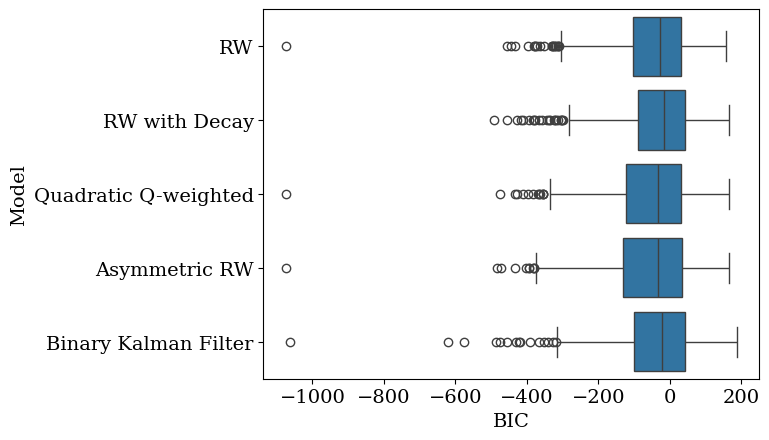

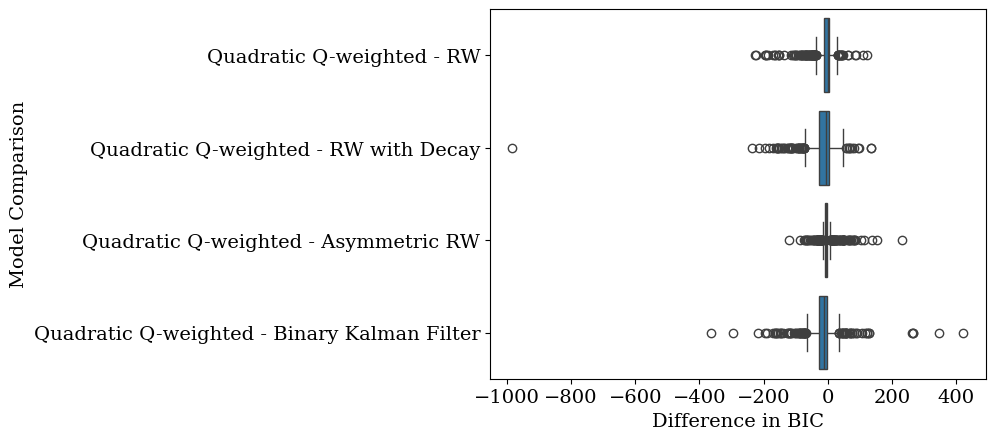

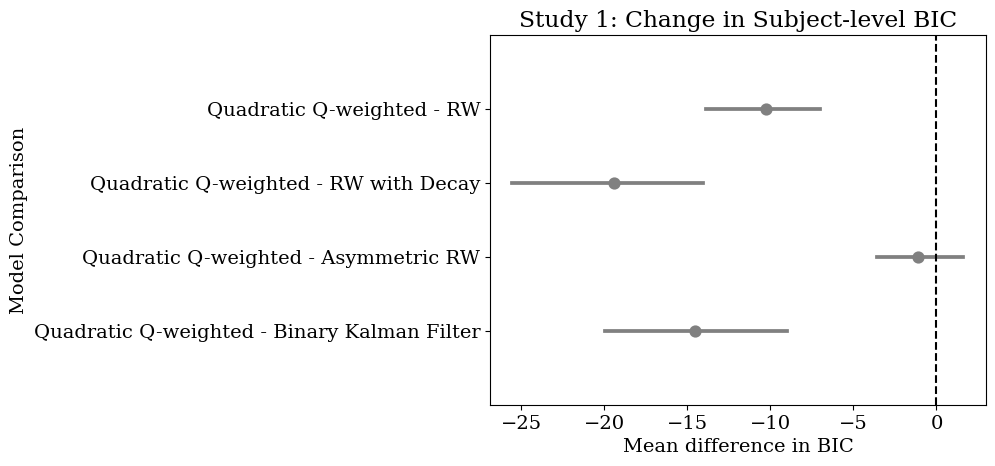

In [7]:
biclist = []; modlist = []; biclist_comp = []; modlist_comp = []
modlabels = ['RW', 'RW with Decay', 'Quadratic Q-weighted', 'Asymmetric RW', 'Binary Kalman Filter']
for i, m in enumerate([testing, testing_decay, testing_sindy, testing_asym, testing_kalman]):
    if i == 0 or i == 1:
        nfpm = 3
    elif i == 2:
        nfpm = 4
    elif i == 3:
        nfpm = 4
    elif i == 4:
        nfpm = 5
    for s in range(1, len(test)+1):
        lik = float(m['log_lik[%s]' % s][0])
        bic = np.log(100)*nfpm-2*lik
        biclist.append(bic)
        modlist.append(modlabels[i])
        if i == 2:
            comp_rw = float(testing['log_lik[%s]' % s][0])
            bic2 = np.log(100)*3-2*comp_rw
            biclist_comp.append(bic - bic2)
            modlist_comp.append('Quadratic Q-weighted - RW')
            comp_decay = float(testing_decay['log_lik[%s]' % s][0])
            bic2 = np.log(100)*3-2*comp_decay
            biclist_comp.append(bic - bic2)
            modlist_comp.append('Quadratic Q-weighted - RW with Decay')
            comp_asym = float(testing_asym['log_lik[%s]' % s][0])
            bic2 = np.log(100)*5-2*comp_asym
            biclist_comp.append(bic - bic2)
            modlist_comp.append('Quadratic Q-weighted - Asymmetric RW')
            comp_kalman = float(testing_kalman['log_lik[%s]' % s][0])
            bic2 = np.log(100)*5-2*comp_kalman
            biclist_comp.append(bic - bic2)
            modlist_comp.append('Quadratic Q-weighted - Binary Kalman Filter')
compdict = {'BIC': biclist, 'Model': modlist}
compdict2 = {'dBIC': biclist_comp, 'Model': modlist_comp}
compdf = pd.DataFrame(compdict)
compdf2 = pd.DataFrame(compdict2)
sns.boxplot(data=compdf, x='BIC', y='Model')
plt.show()
sns.boxplot(data=compdf2, x='dBIC', y='Model')
plt.xlabel('Difference in BIC')
plt.ylabel('Model Comparison')
plt.show()

sns.pointplot(x='dBIC', y='Model', estimator='mean', errorbar='ci', color='grey',
        data=compdf2[::-1], linestyles='none')
plt.plot([0,0], [-1,5], color='black', linestyle='--')
plt.ylim(-1,4)
plt.xlabel('Mean difference in BIC')
plt.ylabel('Model Comparison')
plt.title('Study %s: Change in Subject-level BIC' % study)
plt.show()